In [15]:
from collections import OrderedDict
from torch import tensor
from glob import glob
import os
import matplotlib.pyplot as plt
from numpy import nan
from numpy import array
import numpy as np
def load_eval_file(file):
    try:
        line = eval(open(file, "r").readlines()[-1].strip())
        return line["discriminator_span_acc"].item()
    except:
        return None

def load_downstream_file(file, metric="acc"):
    lines = open(file, "r").readlines()
    for line in lines:
        if "Best score" in line:
            re = line.strip().split(" ")[-1]
            return float(re)
    return None

def load_downstream_fewshot_file(file, metric="acc"):
    lines = open(file, "r").readlines()
    line_num = 0
    for i, line in enumerate(lines):
        if "*** Eval Results ***" in line:
            line_num = i
    for line in lines[line_num:]:
        if "fewshot_validation:" in line:
            re = line.strip().split(" ")[-1]
            return float(re)
        if "fewshot_validation_matched" in line:
            re1 = line.strip().split(" ")[-1]
        if "fewshot_validation_mismatched" in line:
            re2 = line.strip().split(" ")[-1]
            return float(re1), float(re2)
    return None

def load_best_step(file):
    lines = open(file, "r").readlines()
    b_step = None
    for line in lines:
        if "Best score" in line:
            step = int(line.strip().split(" ")[3][:-1])
            if step % 10 == 0:
                b_step = step
    return b_step


In [34]:
# COPA v2, v3
task_to_aug_task = {"qnli": "nli_v2_aug", "snli": "nli_v2_aug", "rte": "nli_v2_aug", "mnli": "nli_v2_aug", "sst2": "sst2_v2_aug", "mr": "sst2_v2_aug", "imdb": "sst2_v2_aug", "piqa": "copa-retrieval0.15", "hellaswag": "copa-retrieval0.15"}
task="qnli"
aug_task = task_to_aug_task[task]
dis_res = []
model="google/electra-base-discriminator"
# model="bert-base-uncased"
if "electra" in model:
    objective = "dis"
else:
    objective = "mlm"
ex_name=f"trainfull"
m = 0
m_step = 0
base_dir=f"/home/ubuntu/space3/out/hf/train/{objective}/{model}/{aug_task}/{ex_name}"
b_eval_step=load_best_step(os.path.join(base_dir, f"log.out"))
max_step = 38000
for step in range(1000, max_step+1000, 1000):
    output=f"{base_dir}/checkpoint-{step}"
    file = os.path.join(output, f"eval_{task}.log")
    re = load_downstream_fewshot_file(file)
    dis_res.append(re)
    if step == b_eval_step:
        print("best eval:", b_eval_step, re)
    if re is not None:
        re = re if isinstance(re, float) else re[0]
    if re is not None and re > m:
        m = re
        m_step = step
        
print("2 epochs:", dis_res[-1])
print("max:", m_step, m)

best eval: 38000 0.5152846574783325
2 epochs: 0.5152846574783325
max: 12000 0.5339556932449341


In [22]:
dis_res[4]

(0.3584309730005094, 0.354759967453214)

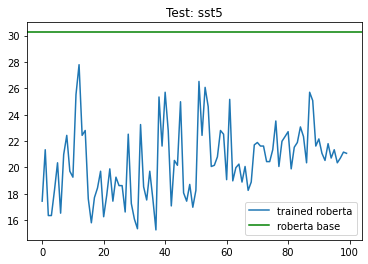

In [49]:
task = "sst5"
model_task="sst5"
roberta_acc = {"sst2": 77.75, "imdb": 63.22, "rte": 53.43, "sst5": 30.25, "trec": 45.00, "subj": 53.80, "mr": 71.85, "mnlimatched": 48.23}
electra_acc = {"sst2": 82.8, "imdb": 82.44, "rte": 57.76, "sst5": 31.06, "trec": 35.80, "subj": 50.05, "mr": 81.45, "mnlimatched": 51.82}
steps = {"sst2": 23500, "nli": 5000, "sst5": 5000, "trec": 600, "subj": 900}

x = list(range(500, steps[model_task], 500))

plt.plot(range(len(mlm_res)), mlm_res, label="trained roberta")
# plt.plot(range(len(dis_res)), dis_res, label="trained electra")
# plt.ylim([0.45, 0.55])
if roberta_acc[task] is not None:
    plt.axhline(roberta_acc[task], label="roberta base", color="green")
# if electra_acc[task] is not None:
#     plt.axhline(electra_acc[task], label="electra base", color="red")

plt.legend()
plt.title(f"Test: {task}")
plt.savefig(f"images/new_images/{task}.pdf")